<a href="https://colab.research.google.com/github/joblazek/psp-auction/blob/main/Algorithm1_async.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import threading
import time
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List, Optional
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

np.random.seed(12345)
np.set_printoptions(precision=4)

class Seller:
    """Holds bids for a PSP auction."""
    def __init__(self, j: int, Q_max: float, epsilon: float):
        self.j = j
        self.Q_max = Q_max
        self.s: Dict[str, Tuple[float, float]] = {}
        self.epsilon = epsilon
        self.lock = threading.Lock()
        self.listeners: List['buyer'] = []

    def update_bid(self, i: str, s_i: Tuple[float, float]):
        """Update the bid profile s_i = (q_i, p_i) for buyer i; notify all listeners."""
        with self.lock:
            self.s[i] = s_i
            #print("Buyer ", i, " updated to ", s_i)
            # Notify buyers so they can recompute
            for listener in self.listeners:
                listener.notify_update()

    def register_listener(self, buyer: 'buyer'):
        """buyers call this to receive bid-update notifications."""
        self.listeners.append(buyer)

    def get_s_hat_minus(self, i: str) -> Dict[str, Tuple[float, float]]:
        """Retrieve ŝ_{-i}: bids of all buyers except i."""
        with self.lock:
            return {j: s for j, s in self.s.items() if j != i}

class Buyer:
    """
    Implements Algorithm 1 (Lazar & Semret, Appendix B),
    listens for seller updates.

    Initialization:
        s_i = 0
        ŝ_{-i} = ∅

    1. Compute truthful ε-best reply t_i = (v_i, w_i):
        v_i = [ sup G_i(ŝ_{-i}) – ε / θ_i′(0) ]_+
        w_i = θ_i′(v_i)

        where sup G_i(ŝ_{-i}) is
        sup { z ∈ [0, Q] :
              z ≤ Q_i(θ_i′(z), ŝ_{-i})
           and ∫₀ᶻ P_i(ζ, ŝ_{-i}) dζ ≤ b_i }

    2. If u_i(t_i, ŝ_{-i}) > u_i(s_i, ŝ_{-i}) + ε, then
           s_i ← t_i

    3. Sleep 1 second and repeat.
    """
    def __init__(self,
                 i: str,
                 epsilon: float,
                 b_i: float,
                 q_i: float,
                 kappa_i: float,
                 sellers: List[Seller]):
        """
        :param i: buyer id
        :param epsilon: threshold ε
        :param b_i: budget
        :param q_i: max physical quantity
        :param kappa_i: valuation intensity
        :param sellers: the sellers this buyer bids on
        """
        self.i = i
        self.epsilon = epsilon  # convergence threshold
        self.b_i = b_i          # budget constraint
        self.q_i = q_i          # capacity (max quantity)
        self.kappa_i = kappa_i  # valuation intensity
        self.sellers = sellers

        # Current bid (q_i, p_i)
        self.s_i: Dict[Seller, Tuple[float, float]] = {} # Changed key type to Seller
        for l in self.sellers:
          self.s_i[l] = (0.0, 0.0)
          l.update_bid(self.i, self.s_i[l]) # Pass the bid for the specific seller

        # Concurrency primitives
        self.update_event = threading.Event()
        self.running = True

        # Register for updates
        for l in self.sellers:
            l.register_listener(self)

    def notify_update(self):
        """Called by seller when any bid updates."""
        self.update_event.set()

    def theta_i(self, z: float) -> float:
        """Valuation θ_i(z), θ(z) = κ * q_i * m - (κ/2) * m^2."""
        m = min(z, self.q_i)
        return self.kappa_i * self.q_i * m - 0.5 * self.kappa_i * m**2

    def theta_i_prime(self, z: float) -> float:
        """Marginal valuation θ'_i(z) = κ * (q_i - z) for z ≤ q_i."""
        if z < self.q_i:
            return self.kappa_i * (self.q_i - z)
        else:
            return 0.0

    def Q_i(self,
            p_i: float,
            seller: Seller,
            s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            Q̄_i(p_i; s_{-i}) = max { Q_max - ∑_{j: p_j > p_i} q_j, 0 }
            where each opponent j requests quantity q_j at price p_j.
            Returns the maximum quantity available to you after fully
            serving all opponents whose bids strictly exceed p_i.
        """
        #print(type(seller), seller.Q_max)
        rem = seller.Q_max
        #print(type(s_hat_minus))
        for qj, pj in s_hat_minus.values():
            if pj > p_i:
                rem -= qj
        return max(rem, 0.0)

    def Q_i_bar(self,
                p_i: float,
                seller: Seller,
                s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Supply excluding bids ≥ p_i."""
        rem = seller.Q_max
        #print("s_hat_minus values in Q_i_bar:", list(s_hat_minus.values())) # Debug print
        for bid in s_hat_minus.values(): # Iterate through the values
            if isinstance(bid, tuple) and len(bid) == 2: # Check if it's a tuple of length 2
                qj, pj = bid
                if pj >= p_i:
                    rem -= qj
            # Optionally, add a warning or handle cases where the bid is not a valid tuple
            # else:
            #     print(f"Warning: Invalid bid format found: {bid}")
        return max(rem, 0.0)


    def P_i(self, z: float,
            seller: Seller,
            s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            P_i(z; ŝ_{-i}) = inf { y ≥ 0 : Q_i(y; ŝ_{-i}) ≥ z }.
            Return the smallest y meeting Q_i(y) ≥ z.
        """
        candidates = sorted({0.0} | {pj for (_, pj) in s_hat_minus.values() if isinstance(pj, (int, float))}) # Added check for float type
        for y in candidates:
            if self.Q_i(y, seller, s_hat_minus) >= z:
                return y
        return float('inf')

    def integral_P(self,
                   z: float,
                   seller: Seller,
                   s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Compute ∫₀ᶻ P_i(ζ, ŝ_{-i}) dζ via simple trapezoidal rule.
                where:
          - z = allocation to i under PSP (infinitely divisible),
          - P_i(z; ŝ_{-i}) = inf{y ≥ 0 : Q_i(y; ŝ_{-i}) ≥ z}.
        """
        N = 100
        zs = np.linspace(0, z, N+1)
        Ps = [self.P_i(z_k, seller, s_hat_minus) for z_k in zs]
        dz = z / N if N > 0 else 0
        return sum((Ps[k] + Ps[k+1]) * 0.5 for k in range(N)) * dz

    def a_i(self,
            s_i: Tuple[float, float],
            seller: Seller,
            s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            a_i(s) = q_i ∧ Q_i(p_i, ŝ_{-i})
        """
        q_i, p_i = s_i
        return min(q_i, self.Q_i_bar(p_i, seller, s_hat_minus))

    def c_i(self,
            s_i: Tuple[float, float],
            seller: Seller,
            s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            c_i(s) = ∫₀^{a_i(s)} P_i(ζ; ŝ_{-i}) dz
        where:
          - a_i(s) = allocation to i under PSP (infinitely divisible),
          - P_i(z; ŝ_{-i}) = inf{y ≥ 0 : Q_i(y; ŝ_{-i}) ≥ z}.
        """
        a = self.a_i(s_i, seller, s_hat_minus)
        return self.integral_P(a, seller, s_hat_minus)

    def u_i(self,
            s_i: Tuple[float, float],
            seller: Seller,
            s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            u_i(s) = θ_i(a_i(s)) − c_i(s)
        """
        a = self.a_i(s_i, seller, s_hat_minus)
        return self.theta_i(a) - self.c_i(s_i, seller, s_hat_minus)

    def sup_G_i(self,
                seller: Seller,
                s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """
            G_i(s_{-i}) = { z ∈ [0, Q_max] :
                z ≤ Q_i(θ'(z); s_{-i}) and ∫₀ᶻ P_i(ζ; s_{-i}) dζ ≤ b_i }
        """
        low, high = 0.0, self.q_i
        for _ in range(20):
            mid = 0.5 * (low + high)
            w = self.theta_i_prime(mid)
            cond1 = (mid <= self.Q_i(w, seller, s_hat_minus))
            cond2 = (self.integral_P(mid, seller, s_hat_minus) <= self.b_i)
            if cond1 and cond2:
                low = mid
            else:
                high = mid
        return low

    def compute_t_i(self,
                    seller: Seller,
                    s_hat_minus: Dict[str, Tuple[float, float]]) -> Tuple[float, float]:
        """
        Compute t_i = (v_i, w_i) per Proposition 1:
            v_i = [sup_G - ε/θ_i′(0)]_+
            w_i = θ_i′(v_i)
        """
        Gsup = self.sup_G_i(seller, s_hat_minus)
        base = self.theta_i_prime(0.0)             # = κ_i * q_i > 0
        adj  = seller.epsilon / base          # use market’s ε
        v    = max(Gsup - adj, 0.0)                # the v_i update
        w    = self.theta_i_prime(v)               # even if v==0, J
        return v, w

    def step(self) -> bool:
        """One Algorithm 1 iteration; return True if s_i updated."""
        updated = False  # Flag to track if any bid was updated
        for l in self.sellers:
          s_hat = l.get_s_hat_minus(self.i)
          old = self.s_i[l]
          t = self.compute_t_i(l, s_hat)
          u_old = self.u_i(old, l, s_hat)
          u_new = self.u_i(t, l, s_hat)
          if u_new > u_old + l.epsilon:
              self.s_i[l] = t
              l.update_bid(self.i, t)
              updated = True # Set flag to True if an update occurred
        return updated # Return the flag

    def run(self, interval: float = 1.0):
        """
        Buyer thread: waits for updates or interval timeout, then steps.
        """
        while self.running:
            # Wait until either notified or interval elapsed
            self.update_event.wait(timeout=interval)
            self.update_event.clear()
            if not self.step():
              self.stop() # Stop if no updates occurred in the step

    def stop(self):
        self.running = False
        self.update_event.set()

    def plot_utility_surface(self,
                             seller: Seller,
                             s_hat_minus: Dict[str, Tuple[float, float]],
                             q_steps: int = 50,
                             p_steps: int = 50) -> None:
        """
        Plot the 3D utility surface u_i(z, w) over (quantity z, price w).
        """
        zs = np.linspace(0, seller.Q_max, q_steps)
        w_max = self.theta_i_prime(0.0)
        ws = np.linspace(0, w_max, p_steps)
        Z, W = np.meshgrid(zs, ws)
        U = np.zeros_like(Z)
        for i in range(p_steps):
            for j in range(q_steps):
                z_val, w_val = Z[i, j], W[i, j]
                U[i, j] = self.u_i((z_val, w_val), seller, s_hat_minus)
        min_u, max_u = U.min(), U.max()
        print(f"Utility range for buyer {self.i}: {min_u:.2f} to {max_u:.2f}")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(Z, W, U, rstride=1, cstride=1)
        ax.set_xlabel('Quantity q_i')
        ax.set_ylabel('Price p_i')
        ax.set_zlabel(f'Utility of {self.i}')
        plt.title(f'Utility Surface for Buyer {self.i}')
        plt.tight_layout()
        plt.show()

    def plot_valuation(self, num_points: int = 100) -> None:
        zs = np.linspace(0, self.q_i, num_points)
        vals = [self.theta_i(z) for z in zs]
        plt.plot(zs, vals, label=f'Buyer {self.i}')

In [19]:
"""
  Helper functions
"""

# Helper: generate N buyers with random parameters

def init_buyers(num_buyers: int,
                start: int,
                sellers: List[Seller],
                budget_range: Tuple[float, float] = (5.0, 20.0),
                q_range: Tuple[float, float] = (1.0, 50.0),
                kappa_range: Tuple[float, float] = (1.0, 3.5),
                epsilon: float = 0.1) -> List[Buyer]:
    """
    Create `num_buyers` instances with random b_i, q_i, kappa_i,
    uniform over provided ranges, all with the same epsilon.
    """
    buyers: List[Buyer] = []
    for idx in range(start, start+num_buyers):
        b_i = random.uniform(*budget_range)
        q_i = random.uniform(*q_range)
        kappa_i = random.uniform(*kappa_range)
        label = f"{idx}"
        buyer = Buyer(label, epsilon, b_i, q_i, kappa_i, sellers)
        buyers.append(buyer)
    return buyers

# Initialization helper

def randbids(buyers: List[Buyer],
             sellers: List[Seller]) -> None:
    """Randomly initialize bids for each buyer on each seller: q_i ~ U[0, q_i], p_i = θ_i'(q_i)."""
    for b in buyers:
        for seller in sellers:
            q = random.uniform(1.0, b.q_i)
            p = b.theta_i_prime(q)
            b.s_i[seller] = (q, p)
            seller.update_bid(b.i, b.s_i[seller])


# Round printing and simulation

def print_round_multi(buyers_by_seller: Dict[Seller, List[Buyer]]) -> None:
    """Display each seller’s round table side-by-side."""
    dfs = []
    for idx, (seller, buyers) in enumerate(buyers_by_seller.items(), start=1):
        df = pd.DataFrame([
            {"Buyer": b.i,
             "q_i": b.s_i.get(seller, (0.0, 0.0))[0], # Access bid for the specific seller
             "p_i": b.s_i.get(seller, (0.0, 0.0))[1], # Access bid for the specific seller
             "a_i": b.a_i(b.s_i.get(seller, (0.0, 0.0)), seller, seller.get_s_hat_minus(b.i)), # Pass seller
             "u_i": b.u_i(b.s_i.get(seller, (0.0, 0.0)), seller, seller.get_s_hat_minus(b.i)), # Pass seller
             "c_i": b.c_i(b.s_i.get(seller, (0.0, 0.0)), seller, seller.get_s_hat_minus(b.i)),} # Pass seller
            for b in buyers
        ])
        # label columns by seller index
        df.columns = pd.MultiIndex.from_product([[f"Seller {idx}"], df.columns])
        dfs.append(df)
    combined = pd.concat(dfs, axis=1)
    print(combined.round(3))

def print_buyers_multi(buyers_by_seller: Dict[Seller, List[Buyer]]) -> None:
    """Print buyers' Q_i and P_i side-by-side for multiple sellers."""
    dfs = []
    for idx, (seller, buyers) in enumerate(buyers_by_seller.items(), start=1):
        df = pd.DataFrame([
            {"Buyer": b.i,
             "Q_i": b.q_i,
             "P_i": b.theta_i_prime(0.0)}
            for b in buyers
        ])
        df.columns = pd.MultiIndex.from_product([[f"Seller {idx}, Q^j {seller.Q_max}, ε {seller.epsilon}"], df.columns])
        dfs.append(df)
    combined = pd.concat(dfs, axis=1)
    print(combined.round(3))

# Market totals helper
def market_totals(buyers: List[Buyer],
                  seller: Seller) -> Tuple[float, float, float]:
    """Compute and print total allocation, total valuation, and total utility of the market."""
    total_alloc = 0.0
    total_value = 0.0
    total_utility = 0.0
    for b in buyers:
        s_hat = seller.get_s_hat_minus(b.i)
        # Access the bid for the specific seller
        bid = b.s_i.get(seller, (0.0, 0.0))
        a = b.a_i(bid, seller, s_hat) # Pass seller
        total_alloc += a
        total_value += b.theta_i(a)
        total_utility += b.u_i(bid, seller, s_hat) # Pass seller
    print(f"Seller {seller.j} -> Q_tot: {total_alloc:.2f}, V_tot: {total_value:.2f}, U_tot: {total_utility:.2f}")

In [20]:

def print_round(r: int,
                changes: int,
                buyers_by_seller: Dict[Seller, List[Buyer]]):
      sellers = list(buyers_by_seller.keys())
      print(f"--- Round {r} ---")
      print_round_multi(buyers_by_seller)
      print(f"Changes this round: {changes}\n")
      for l in sellers:
        market_totals(buyers_by_seller[l], l)



In [21]:
if __name__ == "__main__":
    seller1 = Seller(1, Q_max=50.0, epsilon=5.0)
    seller2 = Seller(2, Q_max=50.0, epsilon=5.0)
    """
    num_buyers: int,
    start: int,
    sellers: List[Seller],
    budget_range: Tuple[float, float] = (5.0, 20.0),
    demand_range: Tuple[float, float] = (1.0, 50.0),
    kappa_range: Tuple[float, float] = (1.0, 3.5),
    epsilon: float = 0.1) -> List[Buyer]:
    """
    all_sellers = [seller1, seller2]
    buyers1 = init_buyers(5, 0, [seller1])
    buyers2 = init_buyers(5, 5, [seller2])
    buyers3 = init_buyers(1, 10, all_sellers) # Buyer 10 bids on both

    # Optional: save parameters
    #save_buyers_by_seller({seller1: buyers1, seller2: buyers2}, "buyers.csv")

    # Optional: load parameters
    #buyers_by_seller = load_buyers_by_seller("buyers.csv", [seller1, seller2])

    # Random initialization of bids
    #randbids(buyers, seller)

    # Plot valuations
    """
    plt.figure()
    for b in buyers:
        b.plot_valuation()
        plt.legend()
        plt.xlabel("Quantity z")
        plt.ylabel("Valuation θ_i(z)")
    """

    buyers_by_seller = {
        seller1: buyers1 + [b for b in buyers3 if seller1 in b.s_i], # Ensure buyer 10 is added only if they bid on seller1
        seller2: buyers2 + [b for b in buyers3 if seller2 in b.s_i], # Ensure buyer 10 is added only if they bid on seller2
    }
    print_buyers_multi(buyers_by_seller)
    #print_round_multi(buyers_by_seller)

    step = 0
    # 1) collect each unique buyer exactly once
    all_buyers = []
    for blist in buyers_by_seller.values():
        for b in blist:
            if b not in all_buyers:
                all_buyers.append(b)

    # 2) start each buyer in its own thread
    threads = []
    for b in all_buyers:
        t = threading.Thread(target=b.run, daemon=True)
        threads.append(t)
        t.start()

    # 3) main reporting loop
    max_rounds = 100
    interval = 0.1
    for round_num in range(1, max_rounds):

        for i in all_buyers:
            i.updated = False

        time.sleep(interval)

        # snapshot current state side-by-side
        print_round(round_num, sum(i.updated for i in all_buyers), buyers_by_seller)

        # check global convergence: no buyer updated
        if not any(i.updated for i in all_buyers):
            print(f"**Global convergence after round {round_num}.**")
            break

    # 3) wait for all buyers to finish
    for t in threads:
        t.join()

    # 4) shut down all buyers
    for b in all_buyers:
        b.stop()



  Seller 1, Q^j 50.0, ε 5.0                  Seller 2, Q^j 50.0, ε 5.0                 
                      Buyer     Q_i      P_i                     Buyer     Q_i      P_i
0                         0  36.075   67.229                         5  31.206   92.817
1                         1  34.528   97.006                         6  30.839  104.813
2                         2  35.895  120.714                         7  36.970   79.072
3                         3  15.945   33.914                         8  38.954   74.546
4                         4   2.706    6.173                         9  31.402   49.468
5                        10  28.368   30.218                        10  28.368   30.218
--- Round 1 ---
  Seller 1                                         Seller 2                                         
     Buyer     q_i    p_i     a_i      u_i     c_i    Buyer     q_i     p_i     a_i       u_i    c_i
0        0  36.000  0.139   0.000    0.000   0.000        5  31.093   0.337   

Utility range for buyer 7: 0.00 to 1181.85


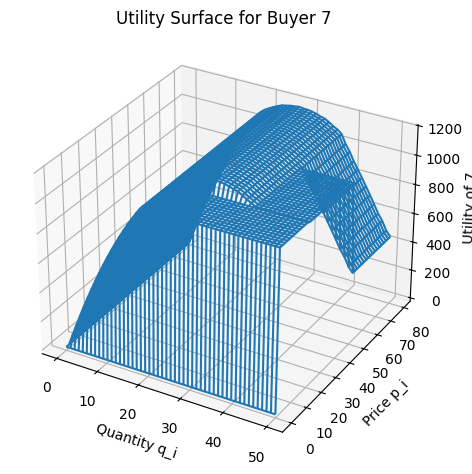

Utility range for buyer 10: 0.00 to 55.03


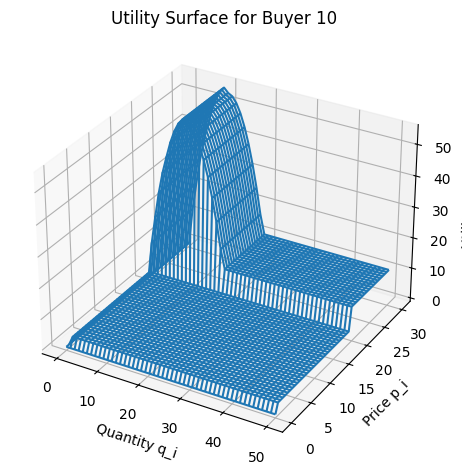

In [22]:

    # Plot utility surface (with s_-i)
    buyers2[2].plot_utility_surface(seller2, seller2.get_s_hat_minus(buyers2[2].i))
    buyers3[0].plot_utility_surface(seller2, seller2.get_s_hat_minus(buyers3[0].i))

In [23]:

# Persistence helpers: save/load the entire buyers_by_seller mapping

def save_buyers_by_seller(buyers_by_seller: Dict[Seller, List[Buyer]], filepath: str) -> None:
    """
    Serialize buyers_by_seller to CSV. Columns:
      seller_idx, buyer_id, epsilon, budget, capacity, kappa, bid_q, bid_p (for each seller)
    """
    rows = []
    # assume consistent ordering of sellers
    seller_list = list(buyers_by_seller.keys())
    for idx, seller in enumerate(seller_list):
        for b in buyers_by_seller[seller]:
            # Find the bid for this specific seller
            if seller in b.s_i:
                q, p = b.s_i[seller]
            else:
                q, p = (0.0, 0.0) # Default if no bid for this seller

            rows.append({
                "seller_idx": idx,
                "buyer_id": b.i,
                "epsilon": b.epsilon,
                "budget": b.b_i,
                "capacity": b.q_i,
                "kappa": b.kappa_i,
                f"bid_q_seller_{idx}": q,
                f"bid_p_seller_{idx}": p
            })
    df = pd.DataFrame(rows)
    df.to_csv(filepath, index=False)


def load_buyers_by_seller(filepath: str,
                          sellers: List[Seller]
                          ) -> Dict[Seller, List[Buyer]]:
    """
    Load buyers_by_seller from CSV. Returns dict mapping each Seller to list of Buyer.
    Sellers list must match the indices used when saving.
    """
    df = pd.read_csv(filepath)
    buyers_by_seller: Dict[Seller, List[Buyer]] = {s: [] for s in sellers}
    loaded_buyers: Dict[str, Buyer] = {}

    for _, row in df.iterrows():
        buyer_id = str(row["buyer_id"])
        if buyer_id not in loaded_buyers:
            buyer = Buyer(
                i=buyer_id,
                epsilon=float(row["epsilon"]),
                b_i=float(row["budget"]),
                q_i=float(row["capacity"]),
                kappa_i=float(row["kappa"]),
                sellers=sellers # Pass all sellers to the buyer
            )
            loaded_buyers[buyer_id] = buyer

        # Restore bids for each seller
        for idx, seller in enumerate(sellers):
             q_key = f"bid_q_seller_{idx}"
             p_key = f"bid_p_seller_{idx}"
             if q_key in row and p_key in row:
                 bid = (float(row[q_key]), float(row[p_key]))
                 loaded_buyers[buyer_id].s_i[seller] = bid
                 seller.update_bid(loaded_buyers[buyer_id].i, bid)

    # Populate buyers_by_seller dictionary
    for seller_idx, seller in enumerate(sellers):
        for _, row in df[df["seller_idx"] == seller_idx].iterrows():
             buyer_id = str(row["buyer_id"])
             if loaded_buyers[buyer_id] not in buyers_by_seller[seller]:
                 buyers_by_seller[seller].append(loaded_buyers[buyer_id])

    return buyers_by_seller

